Cuidado: redefinir badge

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jlfvindel/SW-KG/blob/main/Grafos_RDF/Grafos_RDF.ipynb)

# Resumen

1. **Generación** de un grafo [RDF](https://www.w3.org/TR/rdf11-primer/) implementado como grafo [rdflib](https://rdflib.readthedocs.io/en/stable/index.html)
2. **Visualización**, por conversión a grafo networkx y presentación graphviz
3. **Consulta y administración (SPARQL)**: utilizando el lenguaje estándar [SPARQL](https://www.w3.org/TR/sparql11-overview/)
4. **Consulta y administración (rdflib)**: rdflib permite gestión SPARQL y alternativamente métodos propios sobre el grafo como estructura Python

# Inicialización del cuaderno

## Paquetes: instalación

In [ ]:
%%capture
!pip install pandas rdflib networkx graphviz pydotplus

## Paquetes: importación

In [ ]:
%%capture
# Importación de datos
import pandas as pd
import json

# Generación de grafos RDF 
from rdflib import Graph, URIRef, BNode, Literal
from rdflib.namespace import Namespace, RDF, RDFS

# Visualización vía networkx + visualizadores
import networkx as nx
import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot

## Funciones: datos_json -> grafo_rdf

In [ ]:
# DATOS. Ejemplo simplificado. En este caso, como lista de diccionarios. 
# Nombres como identificadores. Datos relacionales. Juan tiene dos registros.
datos_ej0 = [ 
    {'nombre':'Marcos', 'año_nacimiento':'1962', 'lugar_nacimiento':'Salamanca', 'tiene_madre':'Belén', 'tiene_padre':'Ángel'},
    {'nombre':'Arturo', 'año_nacimiento':'1966', 'tiene_madre':'Belén', 'tiene_padre':'Ángel'},
    {'nombre':'Pedro', 'año_nacimiento':'1979', 'lugar_nacimiento':'Badajoz', 'tiene_madre':'Inés', 'tiene_padre':'Pablo'},
    {'nombre':'Luis', 'año_nacimiento':'1984', 'lugar_nacimiento':'Madrid', 'tiene_madre':'Isabel', 'tiene_padre':'Jorge'},
    {'nombre':'Ana', 'año_nacimiento':'1982', 'lugar_nacimiento':'Madrid', 'tiene_madre':'Isabel', 'tiene_padre':'Jorge'},
    {'nombre':'Sonia', 'lugar_nacimiento':'Valencia', 'tiene_madre':'María', 'tiene_padre':'Fernando'},
    {'nombre':'Begoña', 'año_nacimiento':'2010', 'lugar_nacimiento':'Madrid', 'tiene_madre':'Sonia', 'tiene_padre':'Pedro'},
    {'nombre':'Marta', 'año_nacimiento':'2015', 'lugar_nacimiento':'Soria', 'tiene_madre':'Ana', 'tiene_padre':'Arturo'},
    {'nombre':'Juan', 'año_nacimiento':'2020', 'lugar_nacimiento':'Teruel', 'tiene_madre':'Ana'},
    {'nombre':'Juan', 'lugar_nacimiento':'Soria', 'tiene_padre':'Pedro'}]

# Impresión de datos, para este ejemplo 
def imprime_datos(datos):
    print(json.dumps(datos, indent=2,  ensure_ascii=False))

# TABLA. DataFrame. En este caso, datos con estructura tabular, quizá con celdas vacías y con filas repetidas.
# Para otros formatos de datos: pd.DataFrame.from_(dict|records), pd.read_(csv|xml|json), pd.json_normalize ...
def datos_a_tabla(datos):
    df = pd.DataFrame.from_records(datos_ej0)
    return df

def imprime_tabla(df):
    display(df)
    
# Lista de 3 tuplas.     
def tabla_a_tuplas3(df,col_idx = 0):
    '''
    Dataframe a 3tuplas (sujeto_celda_fila_X, cabecera_columna_Y, valor_celda_X_Y)
    col_idx=N si los sujetos de la 3tupla no están en la columna 0 sino en la N
    '''
    columnas = df.columns.values.tolist()
    columna_idx = columnas[col_idx]
    columnas.remove(columna_idx)

    ternas = []
    for fila in df.index:
        for columna in columnas:
            sujeto_t = df[columna_idx][fila]
            predicado_t = columna
            objeto_t = df[columna][fila]
            if pd.notnull(objeto_t):
                terna = (sujeto_t, predicado_t, objeto_t)
                ternas.append(terna)
    return ternas

def imprime_tuplas3(tuplas3):
    display(tuplas3)
    
# GRAFO: creación
def tuplas3_a_grafo(tuplas3):
    G = nx.DiGraph()
    for tupla in tuplas3:
        #G.add_node(terna[0])
        #G.add_node(terna[2])
        G.add_edge(tupla[0], tupla[2], label=tupla[1])
    return G

    
def tuplas3_a_grafoRDFLib(tuplas3,ns0='http://example.org/recursos#',ns1='http://example.org/propiedades#'):
    g = Graph()
    for tupla in tuplas3:
        sujeto = URIRef(ns0 + tupla[0])
        predicado = URIRef(ns1 + tupla[1])
        predicados_con_objeto_literal = ['año_nacimiento']
        if tupla[1] in predicados_con_objeto_literal:
            objeto = Literal(tupla[2])
        else:
            objeto = URIRef(ns0 + tupla[2])
        
        ternaRDF=(sujeto,predicado,objeto)
        g.add(ternaRDF)
    return g 


## Generación de un grafo RDF

### Datos iniciales
Como datos de entrada, lo usual es partir de un fichero o de una consulta que devuelve un dataset. Para este ejemplo sencillo se parte de una pequeña 'tabla', en forma de lista de diccionarios.

In [1]:
pers = [ 
    {'nombre':'Marcos', 'año_nacimiento':'1962', 'lugar_nacimiento':'Salamanca', 'tiene_madre':'Belén', 'tiene_padre':'Ángel'},
    {'nombre':'Arturo', 'año_nacimiento':'1966', 'lugar_nacimiento':'Salamanca', 'tiene_madre':'Belén', 'tiene_padre':'Ángel'},
    {'nombre':'Pedro', 'año_nacimiento':'1979', 'lugar_nacimiento':'Badajoz', 'tiene_madre':'Inés', 'tiene_padre':'Pablo'},
    {'nombre':'Luis', 'año_nacimiento':'1984', 'lugar_nacimiento':'Madrid', 'tiene_madre':'Isabel', 'tiene_padre':'Jorge'},
    {'nombre':'Ana', 'año_nacimiento':'1982', 'lugar_nacimiento':'Madrid', 'tiene_madre':'Isabel', 'tiene_padre':'Jorge'},
    {'nombre':'Sonia', 'año_nacimiento':'1980', 'lugar_nacimiento':'Valencia', 'tiene_madre':'María', 'tiene_padre':'Fernando'},
    {'nombre':'Begoña', 'año_nacimiento':'2010', 'lugar_nacimiento':'Madrid', 'tiene_madre':'Sonia', 'tiene_padre':'Pedro'},
    {'nombre':'Marta', 'año_nacimiento':'2015', 'lugar_nacimiento':'Soria', 'tiene_madre':'Ana', 'tiene_padre':'Arturo'},
    {'nombre':'Juan', 'año_nacimiento':'2020', 'lugar_nacimiento':'Teruel', 'tiene_madre':'Ana', 'tiene_padre':'Pedro'} ]

#print(f"{pers[0]['nombre']} nació en {pers[0]['año_nacimiento']} en {pers[0]['lugar_nacimiento']}")

Se presentan los datos en un DataFrame, para facilitar su lectura.

In [2]:
import pandas as pd
import json

In [3]:
pers_df = pd.DataFrame(pers)
display(pers_df)

#print(f"{pers_df['nombre'][0]} nació en {pers_df['año_nacimiento'][0]} en {pers_df['lugar_nacimiento'][0]}")

,nombre,año_nacimiento,lugar_nacimiento,tiene_madre,tiene_padre
0,Marcos,1962,Salamanca,Belén,Ángel
1,Arturo,1966,Salamanca,Belén,Ángel
2,Pedro,1979,Badajoz,Inés,Pablo
3,Luis,1984,Madrid,Isabel,Jorge
4,Ana,1982,Madrid,Isabel,Jorge
5,Sonia,1980,Valencia,María,Fernando
6,Begoña,2010,Madrid,Sonia,Pedro
7,Marta,2015,Soria,Ana,Arturo
8,Juan,2020,Teruel,Ana,Pedro


### Espacios de nombres
Con los datos de la tabla anterior se generan tripletas (\<sujeto\> \<predicado\> \<objeto\>) como las siguientes:
+ \<Juan\> \<año_de_nacimiento\> "2020"
+ \<Juan\> \<tiene_madre\> \<Ana\>

Tan sólo en los objetos, en la tercera componente de las tripletas, se pueden utilizar literales cuando convenga. El resto de las entidades requieren un identificador único, de tipo URIRef en rdflib, que se inician con direcciones URI o IRI escogidas.

In [4]:
from rdflib import Graph, URIRef, BNode, Literal
from rdflib.namespace import Namespace, RDF, RDFS

In [5]:
EXR = Namespace("http://example.org/recursos#")
EXP = Namespace("http://example.org/propiedades#")

# Test. Recursos citados desde la lista de diccionarios 'pers'
print(URIRef(EXR + pers[0]['nombre']))
print(URIRef(EXP.año_nacimiento))
print(Literal(pers[0]['año_nacimiento']))

http://example.org/recursos#Marcos
http://example.org/propiedades#año_nacimiento
1962


### Generación del grafo
Se recorre la lista de diccionarios `pers` y, para cada `nombre` se genera una tripleta con su año de nacimiento, su lugar de nacimiento, su madre y su padre.

In [6]:
g = Graph()

for p in pers:
    sujeto = URIRef(EXR + p['nombre'])
    for key, value in p.items():
        if key=='nombre':
            pass
        elif key=='año_nacimiento' :
            g.add( (sujeto, URIRef(EXP + key), Literal(value)) )
        else:
            g.add( (sujeto, URIRef(EXP + key), URIRef(EXR + value)) )

### Serialización del grafo
Para la presentación secuencial del grafo en un fichero hay [varios formatos](https://rdflib.readthedocs.io/en/stable/plugin_serializers.html) posibles. El más legible es `turtle`.

In [7]:
# Serialización del grafo RDF creado, en formato Turtle.
print(g.serialize(format='turtle'))

@prefix ns1: <http://example.org/propiedades#> .

<http://example.org/recursos#Begoña> ns1:año_nacimiento "2010" ;
    ns1:lugar_nacimiento <http://example.org/recursos#Madrid> ;
    ns1:tiene_madre <http://example.org/recursos#Sonia> ;
    ns1:tiene_padre <http://example.org/recursos#Pedro> .

<http://example.org/recursos#Juan> ns1:año_nacimiento "2020" ;
    ns1:lugar_nacimiento <http://example.org/recursos#Teruel> ;
    ns1:tiene_madre <http://example.org/recursos#Ana> ;
    ns1:tiene_padre <http://example.org/recursos#Pedro> .

<http://example.org/recursos#Luis> ns1:año_nacimiento "1984" ;
    ns1:lugar_nacimiento <http://example.org/recursos#Madrid> ;
    ns1:tiene_madre <http://example.org/recursos#Isabel> ;
    ns1:tiene_padre <http://example.org/recursos#Jorge> .

<http://example.org/recursos#Marcos> ns1:año_nacimiento "1962" ;
    ns1:lugar_nacimiento <http://example.org/recursos#Salamanca> ;
    ns1:tiene_madre <http://example.org/recursos#Belén> ;
    ns1:tiene_padre <http:/

## Visualización del grafo inicial
Se añade una función de visualización, via networkx y graphviz, que se encuentra en el siguiente cuaderno Colab: [https://colab.research.google.com/github/joerg84/Graph_Powered_ML_Workshop/blob/master/Sparql.ipynb](https://colab.research.google.com/github/joerg84/Graph_Powered_ML_Workshop/blob/master/Sparql.ipynb).

In [8]:
import networkx as nx
import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot

In [9]:
def visualiza(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))

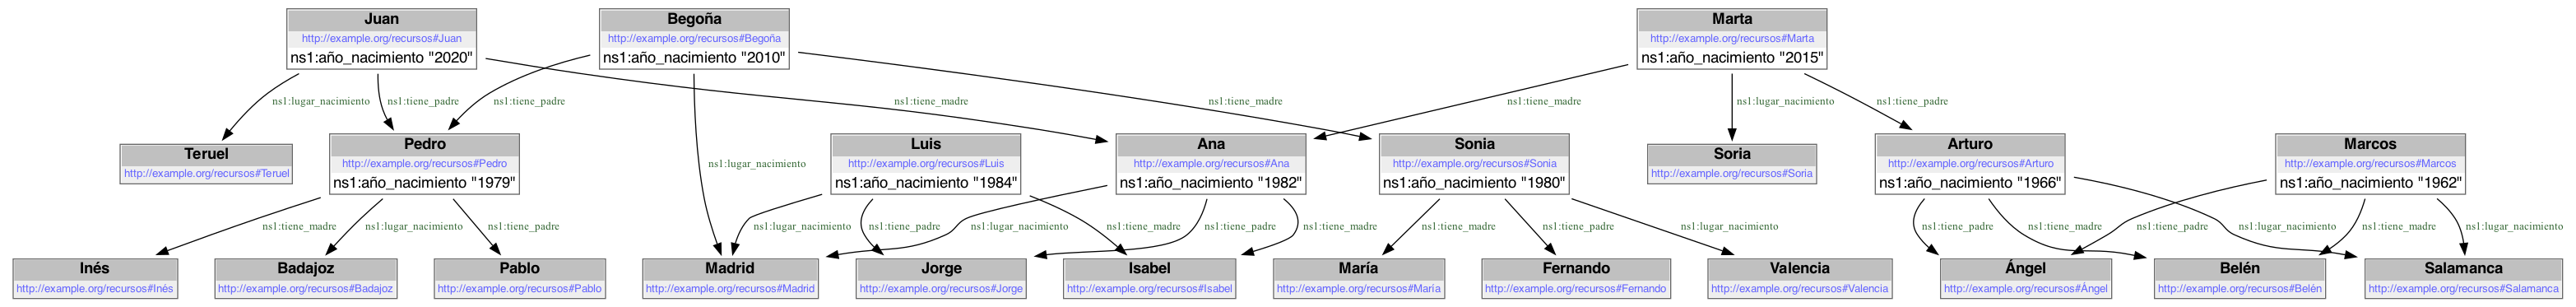

In [10]:
visualiza(g)

## Consultas y actualización (SPARQL)
RDFLib permite consultar y administrar el grafo **de dos formas complementarias**:
+ mediante el lenguaje estándar de consulta y administración SPARQL
+ mediante gestión directa y a bajo nivel de los objetos Python del grafo

### Consultas (SPARQL)
**Ejemplo 1**. Consulta SELECT: de cada coincidencia del patrón declarado en WHERE con el grafo, se devuelve la n-tupla de instancias de las variables en SELECT. En este caso, (?s,?m,?p): de cada persona, tanto su madre como su padre.

In [11]:
consulta1='''
  PREFIX rec: <http://example.org/recursos#>
  PREFIX prop: <http://example.org/propiedades#>
  SELECT ?s ?m ?p
  WHERE {
    ?s prop:tiene_madre ?m ;
       prop:tiene_padre ?p .
  }
'''
resultados1 = g.query(consulta1)

for fila in resultados1:
    print(f"{fila.s}, madre: {fila.m}, padre: {fila.p}")

http://example.org/recursos#Marcos, madre: http://example.org/recursos#Belén, padre: http://example.org/recursos#Ángel
http://example.org/recursos#Arturo, madre: http://example.org/recursos#Belén, padre: http://example.org/recursos#Ángel
http://example.org/recursos#Pedro, madre: http://example.org/recursos#Inés, padre: http://example.org/recursos#Pablo
http://example.org/recursos#Luis, madre: http://example.org/recursos#Isabel, padre: http://example.org/recursos#Jorge
http://example.org/recursos#Ana, madre: http://example.org/recursos#Isabel, padre: http://example.org/recursos#Jorge
http://example.org/recursos#Sonia, madre: http://example.org/recursos#María, padre: http://example.org/recursos#Fernando
http://example.org/recursos#Begoña, madre: http://example.org/recursos#Sonia, padre: http://example.org/recursos#Pedro
http://example.org/recursos#Marta, madre: http://example.org/recursos#Ana, padre: http://example.org/recursos#Arturo
http://example.org/recursos#Juan, madre: http://examp

**Ejemplo 2**. De cada persona ?s devuelve sus antecesores ?a en el grafo. Esto ocurre si hay un camino desde ?s hasta ?a en el que cada paso, cada eje o relación recorrida es o bien 'tiene_madre' o bien 'tiene_padre'.

In [12]:
consulta2='''
  PREFIX rec: <http://example.org/recursos#>
  PREFIX prop: <http://example.org/propiedades#>
  SELECT ?s ?a
  WHERE {
    ?s (prop:tiene_madre | prop:tiene_padre)+ ?a .
  }
'''
resultados2 = g.query(consulta2)

for fila in resultados2:
    print(f"{fila.s}, tiene_antecesor: {fila.a}")

http://example.org/recursos#Marcos, tiene_antecesor: http://example.org/recursos#Belén
http://example.org/recursos#Marcos, tiene_antecesor: http://example.org/recursos#Ángel
http://example.org/recursos#Arturo, tiene_antecesor: http://example.org/recursos#Belén
http://example.org/recursos#Arturo, tiene_antecesor: http://example.org/recursos#Ángel
http://example.org/recursos#Pedro, tiene_antecesor: http://example.org/recursos#Inés
http://example.org/recursos#Pedro, tiene_antecesor: http://example.org/recursos#Pablo
http://example.org/recursos#Luis, tiene_antecesor: http://example.org/recursos#Isabel
http://example.org/recursos#Luis, tiene_antecesor: http://example.org/recursos#Jorge
http://example.org/recursos#Ana, tiene_antecesor: http://example.org/recursos#Isabel
http://example.org/recursos#Ana, tiene_antecesor: http://example.org/recursos#Jorge
http://example.org/recursos#Sonia, tiene_antecesor: http://example.org/recursos#María
http://example.org/recursos#Sonia, tiene_antecesor: htt

### Actualización (SPARQL)
Actualización (UPDATE) del grafo: permite ejecutar INSERT o DELETE sobre entidades o tripletas seleccionadas en WHERE. En este caso, para cada instancia (?s,?m,?p) en el grafo del patrón en WHERE se insertan tripletas para asignarrespectivamente tanto a ?s como a ?m y a ?p a la clase Persona.

In [13]:
consulta3='''
  PREFIX rec: <http://example.org/recursos#>
  PREFIX prop: <http://example.org/propiedades#>
  INSERT {
    rec:Persona rdf:type rdfs:Class .
    ?s rdf:type rec:Persona .
    ?m rdf:type rec:Persona .
    ?p rdf:type rec:Persona .
  }
  WHERE {
    ?s prop:tiene_madre ?m ;
       prop:tiene_padre ?p .
  }
'''
g.update(consulta3)

print(g.serialize(format='turtle'))

@prefix ns1: <http://example.org/propiedades#> .
@prefix ns2: <http://example.org/recursos#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .

ns2:Persona a rdfs:Class .

ns2:Begoña a ns2:Persona ;
    ns1:año_nacimiento "2010" ;
    ns1:lugar_nacimiento ns2:Madrid ;
    ns1:tiene_madre ns2:Sonia ;
    ns1:tiene_padre ns2:Pedro .

ns2:Juan a ns2:Persona ;
    ns1:año_nacimiento "2020" ;
    ns1:lugar_nacimiento ns2:Teruel ;
    ns1:tiene_madre ns2:Ana ;
    ns1:tiene_padre ns2:Pedro .

ns2:Luis a ns2:Persona ;
    ns1:año_nacimiento "1984" ;
    ns1:lugar_nacimiento ns2:Madrid ;
    ns1:tiene_madre ns2:Isabel ;
    ns1:tiene_padre ns2:Jorge .

ns2:Marcos a ns2:Persona ;
    ns1:año_nacimiento "1962" ;
    ns1:lugar_nacimiento ns2:Salamanca ;
    ns1:tiene_madre ns2:Belén ;
    ns1:tiene_padre ns2:Ángel .

ns2:Marta a ns2:Persona ;
    ns1:año_nacimiento "2015" ;
    ns1:lugar_nacimiento ns2:Soria ;
    ns1:tiene_madre ns2:Ana ;
    ns1:tiene_padre ns2:Arturo .

ns2:Arturo a ns

## Consulta y actualización (rdflib) 

### Consulta (rdflib)
Esta consulta demanda todas las tripletas del grafo que tienen por propiedad 'lugar de nacimiento'.

In [14]:
for s, p, o in g.triples( (None, EXP.lugar_nacimiento, None) ):
    print(s,p,o)

http://example.org/recursos#Marcos http://example.org/propiedades#lugar_nacimiento http://example.org/recursos#Salamanca
http://example.org/recursos#Arturo http://example.org/propiedades#lugar_nacimiento http://example.org/recursos#Salamanca
http://example.org/recursos#Pedro http://example.org/propiedades#lugar_nacimiento http://example.org/recursos#Badajoz
http://example.org/recursos#Luis http://example.org/propiedades#lugar_nacimiento http://example.org/recursos#Madrid
http://example.org/recursos#Ana http://example.org/propiedades#lugar_nacimiento http://example.org/recursos#Madrid
http://example.org/recursos#Begoña http://example.org/propiedades#lugar_nacimiento http://example.org/recursos#Madrid
http://example.org/recursos#Sonia http://example.org/propiedades#lugar_nacimiento http://example.org/recursos#Valencia
http://example.org/recursos#Marta http://example.org/propiedades#lugar_nacimiento http://example.org/recursos#Soria
http://example.org/recursos#Juan http://example.org/prop

Esta es una consulta similar (véase la [documentación](https://rdflib.readthedocs.io/en/stable/intro_to_graphs.html) de rdflib), que produce pares con las mismas correspondencia (s,o) anteriores.

In [15]:
for s, o in g.subject_objects( EXP.lugar_nacimiento ):
    print(s,o)

http://example.org/recursos#Marcos http://example.org/recursos#Salamanca
http://example.org/recursos#Arturo http://example.org/recursos#Salamanca
http://example.org/recursos#Pedro http://example.org/recursos#Badajoz
http://example.org/recursos#Luis http://example.org/recursos#Madrid
http://example.org/recursos#Ana http://example.org/recursos#Madrid
http://example.org/recursos#Begoña http://example.org/recursos#Madrid
http://example.org/recursos#Sonia http://example.org/recursos#Valencia
http://example.org/recursos#Marta http://example.org/recursos#Soria
http://example.org/recursos#Juan http://example.org/recursos#Teruel


### Actualización (rdflib)
Se añade una terna, que declara la clase Ciudad. Y se inserta, para cada ciudad del grafo, su declaración como instancia de la clase Ciudad.

In [16]:
# Inserción
g.add( (EXR.Ciudad, RDF.type, RDFS.Class) )
for s, p, o in g.triples( (None, EXP.lugar_nacimiento, None) ):
    g.add( (o, RDF.type, EXR.Ciudad) )
    
# Comprobación: listado de las instancias de la clase Ciudad
for s, p, o in g.triples( (None, RDF.type, EXR.Ciudad) ):
    print(s,p,o)

http://example.org/recursos#Salamanca http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://example.org/recursos#Ciudad
http://example.org/recursos#Badajoz http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://example.org/recursos#Ciudad
http://example.org/recursos#Madrid http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://example.org/recursos#Ciudad
http://example.org/recursos#Valencia http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://example.org/recursos#Ciudad
http://example.org/recursos#Soria http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://example.org/recursos#Ciudad
http://example.org/recursos#Teruel http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://example.org/recursos#Ciudad


## Visualización del grafo resultante

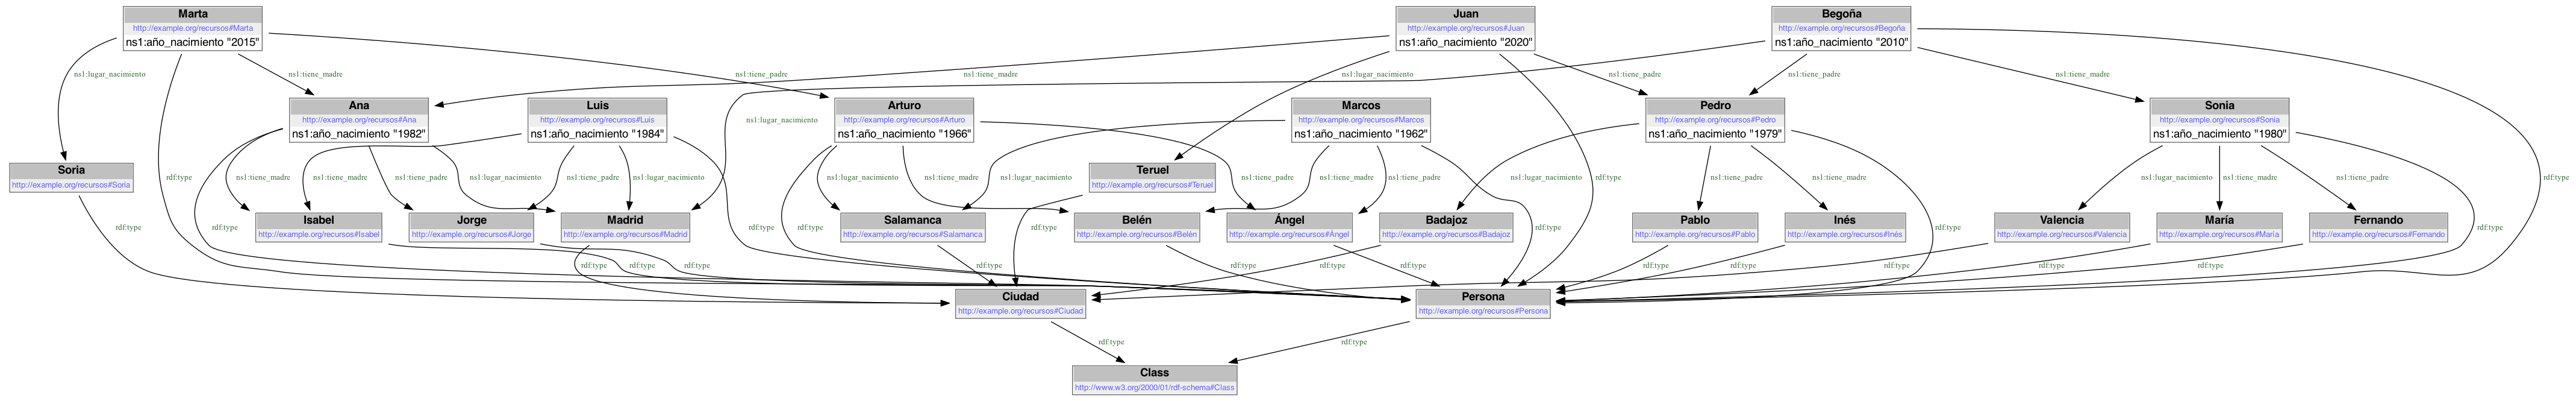

In [17]:
visualiza(g)

# Apéndice: código

In [31]:
%%javascript
//DETECTA el índice de esta celda, para referenciar desde Inicialización
var output_area = this;
var cell_element = output_area.element.parents('.cell');
var cell_idx = Jupyter.notebook.get_cell_elements().index(cell_element);
alert(cell_idx)

<IPython.core.display.Javascript object>

In [ ]:
## Descomentar para instalar
!pip install networkx, pygraphviz, graphviz

In [13]:
import pandas as pd
import json

from rdflib import Graph, URIRef, BNode, Literal
from rdflib.namespace import Namespace, RDF, RDFS

import networkx as nx
import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot

In [14]:
# DATOS. Ejemplo simplificado. En este caso, como lista de diccionarios. 
# Nombres como identificadores. Datos relacionales. Juan tiene dos registros.
datos_ej0 = [ 
    {'nombre':'Marcos', 'año_nacimiento':'1962', 'lugar_nacimiento':'Salamanca', 'tiene_madre':'Belén', 'tiene_padre':'Ángel'},
    {'nombre':'Arturo', 'año_nacimiento':'1966', 'tiene_madre':'Belén', 'tiene_padre':'Ángel'},
    {'nombre':'Pedro', 'año_nacimiento':'1979', 'lugar_nacimiento':'Badajoz', 'tiene_madre':'Inés', 'tiene_padre':'Pablo'},
    {'nombre':'Luis', 'año_nacimiento':'1984', 'lugar_nacimiento':'Madrid', 'tiene_madre':'Isabel', 'tiene_padre':'Jorge'},
    {'nombre':'Ana', 'año_nacimiento':'1982', 'lugar_nacimiento':'Madrid', 'tiene_madre':'Isabel', 'tiene_padre':'Jorge'},
    {'nombre':'Sonia', 'lugar_nacimiento':'Valencia', 'tiene_madre':'María', 'tiene_padre':'Fernando'},
    {'nombre':'Begoña', 'año_nacimiento':'2010', 'lugar_nacimiento':'Madrid', 'tiene_madre':'Sonia', 'tiene_padre':'Pedro'},
    {'nombre':'Marta', 'año_nacimiento':'2015', 'lugar_nacimiento':'Soria', 'tiene_madre':'Ana', 'tiene_padre':'Arturo'},
    {'nombre':'Juan', 'año_nacimiento':'2020', 'lugar_nacimiento':'Teruel', 'tiene_madre':'Ana'},
    {'nombre':'Juan', 'lugar_nacimiento':'Soria', 'tiene_padre':'Pedro'}]

In [24]:
# Impresión de datos, para este ejemplo 
def imprime_datos(datos):
    print(json.dumps(datos, indent=2,  ensure_ascii=False))

# TABLA. DataFrame. En este caso, datos con estructura tabular, quizá con celdas vacías y con filas repetidas.
# Para otros formatos de datos: pd.DataFrame.from_(dict|records), pd.read_(csv|xml|json), pd.json_normalize ...
def datos_a_tabla(datos):
    df = pd.DataFrame.from_records(datos_ej0)
    return df

def imprime_tabla(df):
    display(df)
    
# Lista de 3 tuplas.     
def tabla_a_tuplas3(df,col_idx = 0):
    '''
    Dataframe a 3tuplas (sujeto_celda_fila_X, cabecera_columna_Y, valor_celda_X_Y)
    col_idx=N si los sujetos de la 3tupla no están en la columna 0 sino en la N
    '''
    columnas = df.columns.values.tolist()
    columna_idx = columnas[col_idx]
    columnas.remove(columna_idx)

    ternas = []
    for fila in df.index:
        for columna in columnas:
            sujeto_t = df[columna_idx][fila]
            predicado_t = columna
            objeto_t = df[columna][fila]
            if pd.notnull(objeto_t):
                terna = (sujeto_t, predicado_t, objeto_t)
                ternas.append(terna)
    return ternas

def imprime_tuplas3(tuplas3):
    display(tuplas3)
    
# GRAFO: creación
def tuplas3_a_grafo(tuplas3):
    G = nx.DiGraph()
    for tupla in tuplas3:
        #G.add_node(terna[0])
        #G.add_node(terna[2])
        G.add_edge(tupla[0], tupla[2], label=tupla[1])
    return G

    
def tuplas3_a_grafoRDFLib(tuplas3,ns0='http://example.org/recursos#',ns1='http://example.org/propiedades#'):
    g = Graph()
    for tupla in tuplas3:
        sujeto = URIRef(ns0 + tupla[0])
        predicado = URIRef(ns1 + tupla[1])
        predicados_con_objeto_literal = ['año_nacimiento']
        if tupla[1] in predicados_con_objeto_literal:
            objeto = Literal(tupla[2])
        else:
            objeto = URIRef(ns0 + tupla[2])
        
        ternaRDF=(sujeto,predicado,objeto)
        g.add(ternaRDF)
    return g   

In [16]:
datos = datos_ej0
imprime_datos(datos)

[
  {
    "nombre": "Marcos",
    "año_nacimiento": "1962",
    "lugar_nacimiento": "Salamanca",
    "tiene_madre": "Belén",
    "tiene_padre": "Ángel"
  },
  {
    "nombre": "Arturo",
    "año_nacimiento": "1966",
    "tiene_madre": "Belén",
    "tiene_padre": "Ángel"
  },
  {
    "nombre": "Pedro",
    "año_nacimiento": "1979",
    "lugar_nacimiento": "Badajoz",
    "tiene_madre": "Inés",
    "tiene_padre": "Pablo"
  },
  {
    "nombre": "Luis",
    "año_nacimiento": "1984",
    "lugar_nacimiento": "Madrid",
    "tiene_madre": "Isabel",
    "tiene_padre": "Jorge"
  },
  {
    "nombre": "Ana",
    "año_nacimiento": "1982",
    "lugar_nacimiento": "Madrid",
    "tiene_madre": "Isabel",
    "tiene_padre": "Jorge"
  },
  {
    "nombre": "Sonia",
    "lugar_nacimiento": "Valencia",
    "tiene_madre": "María",
    "tiene_padre": "Fernando"
  },
  {
    "nombre": "Begoña",
    "año_nacimiento": "2010",
    "lugar_nacimiento": "Madrid",
    "tiene_madre": "Sonia",
    "tiene_padre": "Pedro"


In [17]:
tabla = datos_a_tabla(datos)
imprime_tabla(tabla)

,nombre,año_nacimiento,lugar_nacimiento,tiene_madre,tiene_padre
0,Marcos,1962,Salamanca,Belén,Ángel
1,Arturo,1966,NaN,Belén,Ángel
2,Pedro,1979,Badajoz,Inés,Pablo
3,Luis,1984,Madrid,Isabel,Jorge
4,Ana,1982,Madrid,Isabel,Jorge
5,Sonia,NaN,Valencia,María,Fernando
6,Begoña,2010,Madrid,Sonia,Pedro
7,Marta,2015,Soria,Ana,Arturo
8,Juan,2020,Teruel,Ana,NaN
9,Juan,NaN,Soria,NaN,Pedro


In [20]:
tuplas3 = tabla_a_tuplas3(tabla)
imprime_tuplas3(tuplas3)

[('Marcos', 'año_nacimiento', '1962'),
 ('Marcos', 'lugar_nacimiento', 'Salamanca'),
 ('Marcos', 'tiene_madre', 'Belén'),
 ('Marcos', 'tiene_padre', 'Ángel'),
 ('Arturo', 'año_nacimiento', '1966'),
 ('Arturo', 'tiene_madre', 'Belén'),
 ('Arturo', 'tiene_padre', 'Ángel'),
 ('Pedro', 'año_nacimiento', '1979'),
 ('Pedro', 'lugar_nacimiento', 'Badajoz'),
 ('Pedro', 'tiene_madre', 'Inés'),
 ('Pedro', 'tiene_padre', 'Pablo'),
 ('Luis', 'año_nacimiento', '1984'),
 ('Luis', 'lugar_nacimiento', 'Madrid'),
 ('Luis', 'tiene_madre', 'Isabel'),
 ('Luis', 'tiene_padre', 'Jorge'),
 ('Ana', 'año_nacimiento', '1982'),
 ('Ana', 'lugar_nacimiento', 'Madrid'),
 ('Ana', 'tiene_madre', 'Isabel'),
 ('Ana', 'tiene_padre', 'Jorge'),
 ('Sonia', 'lugar_nacimiento', 'Valencia'),
 ('Sonia', 'tiene_madre', 'María'),
 ('Sonia', 'tiene_padre', 'Fernando'),
 ('Begoña', 'año_nacimiento', '2010'),
 ('Begoña', 'lugar_nacimiento', 'Madrid'),
 ('Begoña', 'tiene_madre', 'Sonia'),
 ('Begoña', 'tiene_padre', 'Pedro'),
 ('Mart

In [25]:
grafo = tuplas3_a_grafoRDFLib(tuplas3)
grafo

<Graph identifier=N61b74689369b4cdd8e9322efbcfbe9b8 (<class 'rdflib.graph.Graph'>)>

In [30]:
print(grafo.serialize(format='turtle'))

@prefix ns1: <http://example.org/propiedades#> .

<http://example.org/recursos#Begoña> ns1:año_nacimiento "2010" ;
    ns1:lugar_nacimiento <http://example.org/recursos#Madrid> ;
    ns1:tiene_madre <http://example.org/recursos#Sonia> ;
    ns1:tiene_padre <http://example.org/recursos#Pedro> .

<http://example.org/recursos#Juan> ns1:año_nacimiento "2020" ;
    ns1:lugar_nacimiento <http://example.org/recursos#Soria>,
        <http://example.org/recursos#Teruel> ;
    ns1:tiene_madre <http://example.org/recursos#Ana> ;
    ns1:tiene_padre <http://example.org/recursos#Pedro> .

<http://example.org/recursos#Luis> ns1:año_nacimiento "1984" ;
    ns1:lugar_nacimiento <http://example.org/recursos#Madrid> ;
    ns1:tiene_madre <http://example.org/recursos#Isabel> ;
    ns1:tiene_padre <http://example.org/recursos#Jorge> .

<http://example.org/recursos#Marcos> ns1:año_nacimiento "1962" ;
    ns1:lugar_nacimiento <http://example.org/recursos#Salamanca> ;
    ns1:tiene_madre <http://example.org/

# Referencias
[exploiting-rdf-with-rdflib.ipynb](https://colab.research.google.com/github/datosgobes/guia-rdf-datosgob/blob/main/rdf-explotacion/exploiting_rdf_with_rdflib.ipynb#scrollTo=C3Vo2CmfMX2O)